In [191]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# стандартизация данных
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize


# библиотека для преобразованя категориальных признаков
from sklearn.preprocessing import OneHotEncoder

In [192]:
df = pd.read_csv('dataset.csv', sep=',')

In [193]:
df['date_reg'] = pd.to_datetime(df['date_reg'], format="%Y-%m-%d")

## Dummy-кодирование категориальных признаков

In [194]:
cat_feat = ['market', 'group', 'archetype', 'hardware', 'channel', 'dealer', 'type_t', 'device']

In [195]:
ohe = OneHotEncoder(sparse=False) 
for j in cat_feat:
    new_ohe_features = ohe.fit_transform(df[j].values.reshape(-1, 1))
    tmp = pd.DataFrame(new_ohe_features, columns=[j + '=' + str(i) for i in range(new_ohe_features.shape[1])], dtype='int64')
    df = pd.concat([df, tmp], axis=1)
    del df[j]

del df['phone']

In [196]:
df.shape

(240000, 253)

## train - test

In [197]:
X_train = df[df['date_reg'] < '2016-05-13']
X_test = df[df['date_reg'] >= '2016-05-13']

y_train = X_train[['client_id', 'churn']]
y_test = X_test[['client_id', 'churn']]

del X_train['churn']
del X_test['churn']
del X_train['date_reg']
del X_test['date_reg']


X_train = X_train.set_index('client_id')
y_train = y_train.set_index('client_id')
X_test = X_test.set_index('client_id')
y_test = y_test.set_index('client_id')

## Нормализация данных


#### Своя реализация
Стандартизация или z-преобразование.  
Преобразование данных в стандартную z-шкалу со средним M=0 и дисперсией D=1.  
z[i] = (x[i] - x.mean()) / sd. 


In [198]:
def standard(df):
    
    def sd(df_series):
        # длина выборки
        n = len(df_series)
        # среднее по выборке
        x_mean = df_series.mean()
        
        df_series_list = df_series.tolist()
        squar_dev = list()
        for i in df_series_list:
            squar_dev.append((i - x_mean)**2)
        
        res = 0
        for j in squar_dev:
            res += j
        res = (res / n) ** (1/2)
        return res
            
            
    
    result = df.copy()
    for feat_name in df.columns:
        if df[feat_name].dtypes in ['int64', 'int32', 'float64', 'float32']:
            n = len(df[feat_name])
            x_mean = df[feat_name].mean()
            x_sd = sd(df[feat_name])
            if x_sd != 0:
                result[feat_name] = (result[feat_name] - x_mean) / x_sd
            else:
                continue
            
    return result

#### Стандартизация. Сравнение своей реализации и sklearn

In [199]:
X_train_standard_own = standard(X_train.copy())
X_test_standard_own = standard(X_test.copy())

In [200]:
#scaler_train = StandardScaler().fit(X_train)
#scaler_test = StandardScaler().fit(X_test)

#df_train_standard_skl = scaler_train.transform(X_train)
#df_test_standard_skl = scaler_test.transform(X_test)

In [201]:
X_train_standard_skl = preprocessing.scale(X_train)
X_test_standard_skl = preprocessing.scale(X_test)

In [202]:
pd.DataFrame(X_train_standard_skl, columns=X_train.columns).head()

,quantity_days_traffic,all_call_in_num,all_call_out_num,all_call_in_dur,all_call_out_dur,all_out_sms,all_gprs,last_day_traffic,mean_call_in_dur,mean_call_out_dur,...,type_t=12,type_t=13,device=0,device=1,device=2,device=3,device=4,device=5,device=6,device=7
0,-0.494013,-0.530785,-0.416299,-0.414354,-0.191049,-0.125198,-0.251583,0.825182,-0.568653,1.396313,...,-0.240799,-0.258500,-0.249128,-0.516828,-0.441214,-0.117551,-0.240799,1.210439,-0.179114,-0.258500
1,0.226848,2.115007,1.328543,0.213687,0.363630,-0.146333,-0.236404,0.825182,-0.317702,-0.294508,...,-0.240799,3.868474,-0.249128,-0.516828,-0.441214,-0.117551,-0.240799,-0.826146,-0.179114,3.868474
2,1.218032,0.897694,0.572815,1.063939,0.795722,-0.167469,-0.242417,0.825182,0.525413,0.206528,...,-0.240799,3.868474,-0.249128,-0.516828,-0.441214,-0.117551,-0.240799,-0.826146,-0.179114,3.868474
3,1.037817,0.276616,0.200508,-0.120141,-0.206267,-0.167469,-0.251583,0.825182,-0.183415,-0.339726,...,-0.240799,-0.258500,-0.249128,1.934881,-0.441214,-0.117551,-0.240799,-0.826146,-0.179114,-0.258500
4,0.136741,-0.282354,-0.366288,-0.327965,-0.455364,-0.114630,-0.251540,0.825182,-0.201025,-0.442138,...,-0.240799,-0.258500,-0.249128,-0.516828,-0.441214,-0.117551,-0.240799,1.210439,-0.179114,-0.258500


In [203]:
pd.DataFrame(X_train_standard_skl, columns=X_train.columns)[['quantity_days_traffic']].describe()

,quantity_days_traffic
count,1.605290e+05
mean,-2.417520e-15
std,1.000003e+00
min,-1.304981e+00
25%,-1.034658e+00
50%,-4.347454e-02
75%,1.037817e+00
max,1.308140e+00


In [204]:
X_train_standard_own[['quantity_days_traffic']].describe()

,quantity_days_traffic
count,1.605290e+05
mean,1.357789e-16
std,1.000003e+00
min,-1.304981e+00
25%,-1.034658e+00
50%,-4.347454e-02
75%,1.037817e+00
max,1.308140e+00


# LogisticRegression

In [205]:
%%time
logit = LogisticRegression(class_weight='balanced')
logit.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wall time: 18.6 s


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

In [206]:
logit_valid_pred = logit.predict_proba(X_test)[:,1]

In [207]:
roc_auc_score(y_test, logit_valid_pred)

0.7459296921754

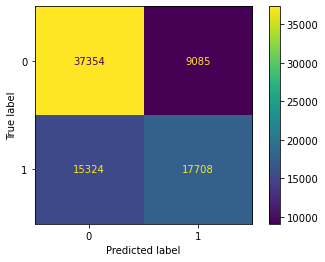

In [208]:
plot_confusion_matrix(logit, X_test, y_test)
plt.show()

# LogisticRegression standard skl

In [209]:
%%time
logit = LogisticRegression(class_weight='balanced')
logit.fit(X_train_standard_skl, y_train)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wall time: 9.03 s


LogisticRegression(class_weight='balanced')

In [210]:
logit_valid_pred = logit.predict_proba(X_test_standard_skl)[:,1]

In [211]:
roc_auc_score(y_test, logit_valid_pred)

0.8467149231816229

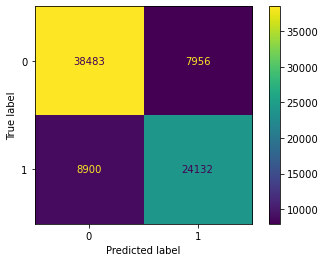

In [212]:
plot_confusion_matrix(logit, X_test_standard_skl, y_test)
plt.show()

# LogisticRegression standard own

In [213]:
%%time
logit = LogisticRegression(class_weight='balanced')
logit.fit(X_train_standard_own, y_train)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wall time: 8.33 s


LogisticRegression(class_weight='balanced')

In [214]:
logit_valid_pred = logit.predict_proba(X_test_standard_own)[:,1]

In [215]:
roc_auc_score(y_test, logit_valid_pred)

0.8467149231816229

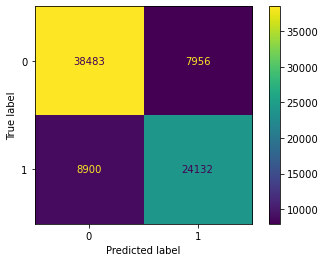

In [216]:
plot_confusion_matrix(logit, X_test_standard_own, y_test)
plt.show()